# Coronavirus Data Analysis

In [1]:
%matplotlib notebook

# Module to send http requests
from requests import get

import matplotlib.pyplot as plt
import pandas as pd

from datetime import date
import statistics as stats

In [2]:
df_utlas = pd.read_csv('utlas.csv', names=["Name"])
df_populations = pd.read_csv('populationestimates2020.csv', header=1)
df_populations['Population'] = df_populations['All ages'].replace(',','',regex=True).fillna(0).astype(int)
df_populations.drop(columns='All ages', inplace=True)

df_utla_populations = df_utlas.merge(df_populations, how='left', on="Name")
df_utla_populations.rename(columns = {"Geography1":"Geography"})

,Name,Code,Geography,Population
0,Antrim and Newtownabbey,N09000001,Local Government District,143504.0
1,Ards and North Down,N09000011,Local Government District,161725.0
2,"Armagh City, Banbridge and Craigavon",N09000002,Local Government District,216205.0
3,Barking and Dagenham,E09000002,London Borough,212906.0
4,Barnet,E09000003,London Borough,395869.0
...,...,...,...,...
177,Wokingham,E06000041,Unitary Authority,171119.0
178,Wolverhampton,E08000031,Metropolitan District,263357.0
179,Worcestershire,E10000034,County,595786.0
180,Wrexham,W06000006,Unitary Authority,135957.0


In [3]:
def rolling_average(values, over):
    result = []
    for i in range(over-1):
        result.append(None)
    for i in range(len(values)-over+1):
        result.append(stats.mean(values[i:i+over]))
    return result

In [ ]:
def get_data(url):
    response = get(endpoint, timeout=10)
    if response.status_code >= 400:
      raise RuntimeError(f'Request failed: { response.text }')
    return response.json()

In [4]:
def join_on_date(dfs):
    # Takes a dictionary of dataframes
    result = pd.DataFrame()
    for suffix, df in dfs.items():
        if result.empty:
            result = df.rename(columns={f"date{suffix.replace(' ','')}":'date'})
        else:
            result = result.merge(df, left_on='date', right_on=f"date{suffix.replace(' ','')}")
            result['date'].fillna(result[f"date{suffix.replace(' ','')}"], inplace=True)
            del result[f"date{suffix.replace(' ','')}"]
    result['date'] = result['date'].map(date.fromisoformat)
    return result

In [5]:
nations = ['England', 'Scotland', 'Wales', 'Northern Ireland']

nation_dfs = {}
for nation in nations:
    print(f'processing {nation}')
    endpoint = (
      'https://api.coronavirus.data.gov.uk/v1/data?'
      f'filters=areaType=nation;areaName={nation}&'
      'structure={"date":"date","newCases":"newCasesByPublishDate", "newDeaths":"newDeaths28DaysByPublishDate"}'
    )
    data = get_data(endpoint)
    nation_dfs[nation] = pd.DataFrame(data['data'])\
                                .sort_values('date')\
                                .reset_index(drop=True)\
                                .add_suffix(nation.replace(' ',''))


processing England
processing Scotland
processing Wales
processing Northern Ireland


In [6]:
joined_data_nations = join_on_date(nation_dfs)

In [7]:
joined_data_nations.to_csv('data_backup_nations.csv')

<IPython.core.display.Javascript object>


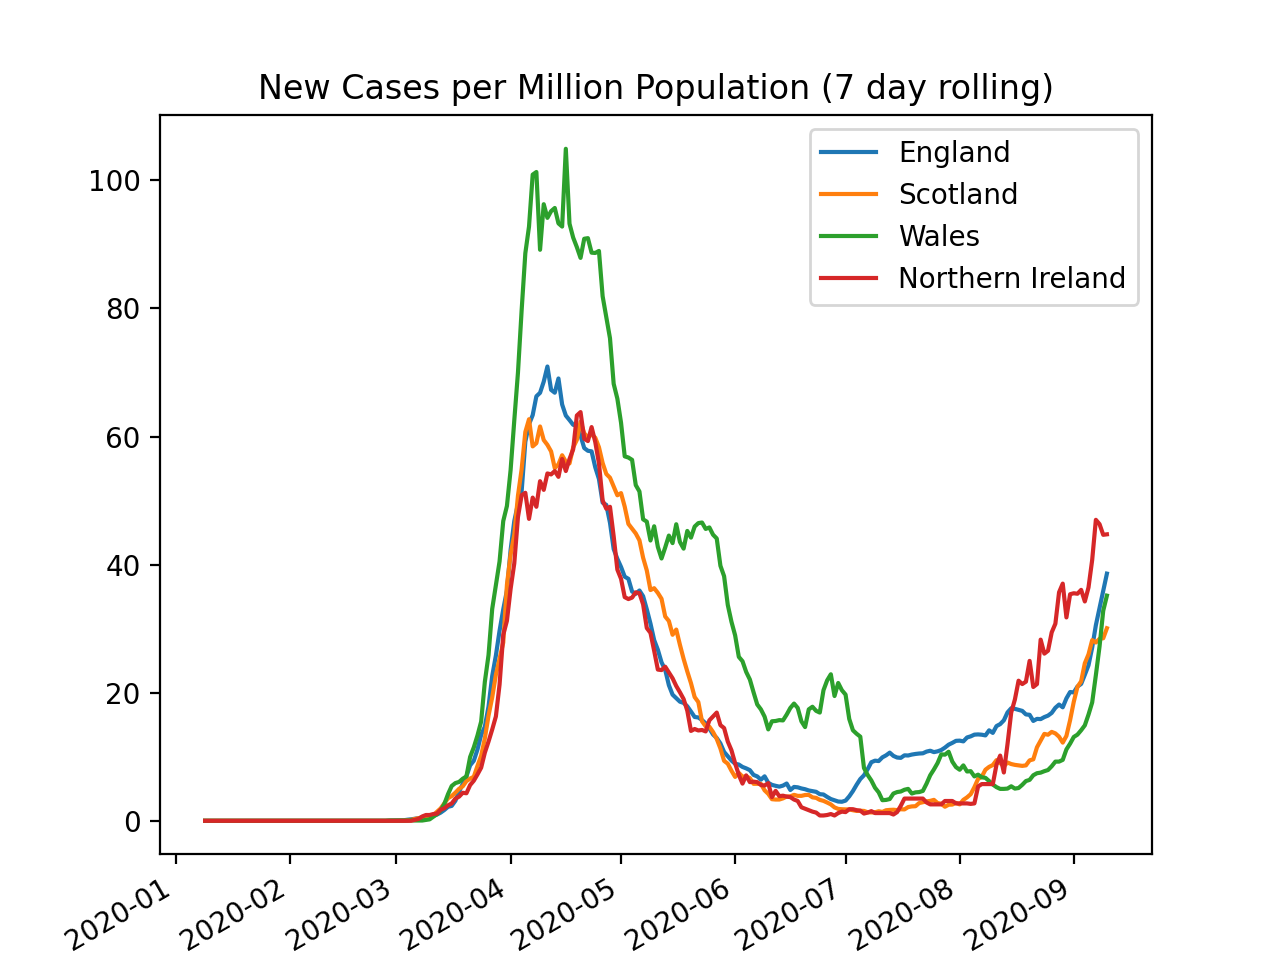

<IPython.core.display.Javascript object>


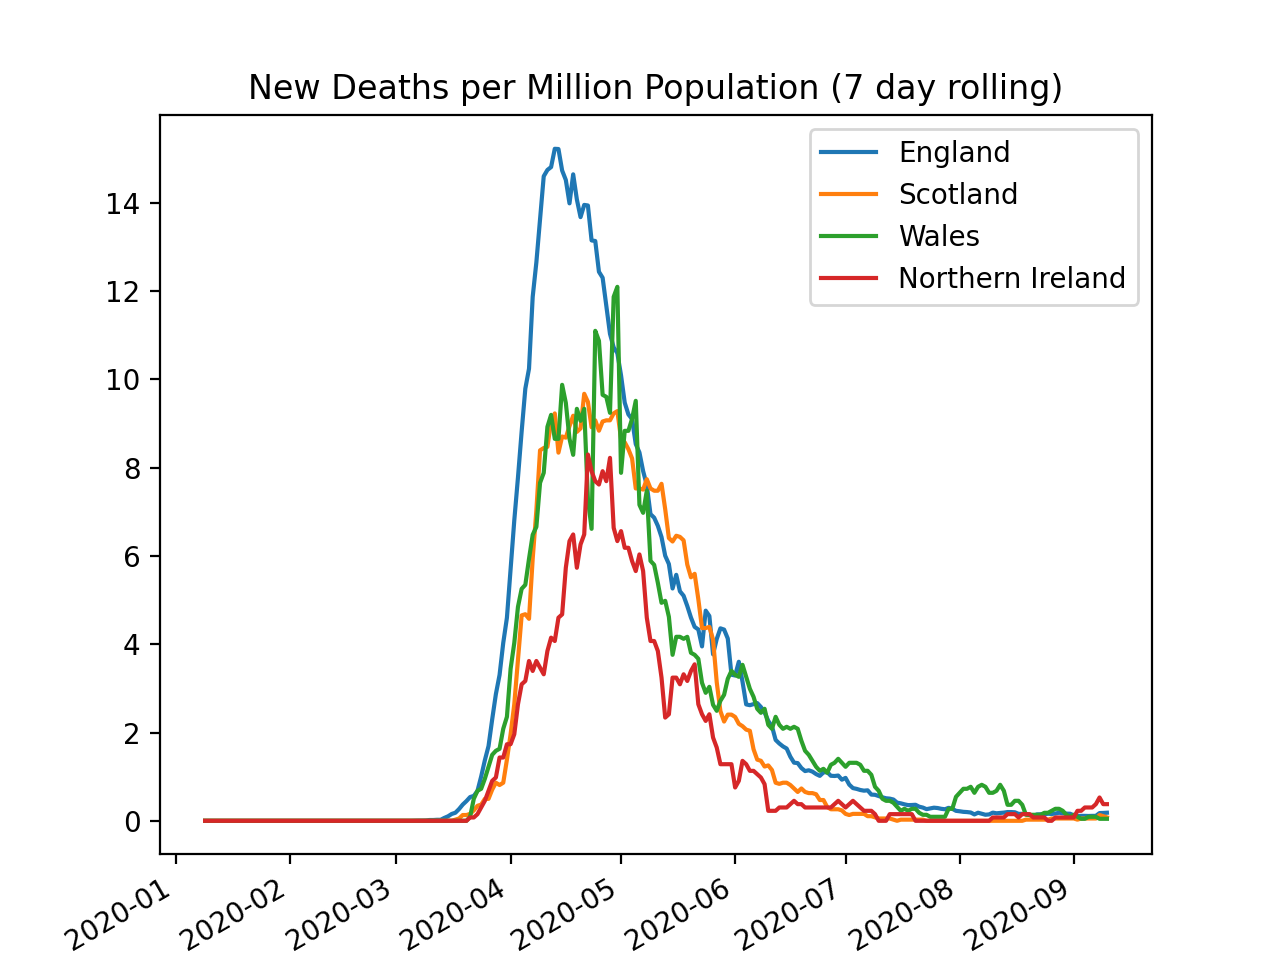

(array([737425., 737456., 737485., 737516., 737546., 737577., 737607.,
        737638., 737669.]),
 <a list of 9 Text major ticklabel objects>)

In [8]:
for nation in nations:
    population_in_millions = int(df_populations[df_populations['Name']==nation.upper()]['Population']) / 10**6
    new_cases = joined_data_nations[f"newCases{nation.replace(' ','')}"]
    new_cases_per_million = joined_data_nations[f"newCases{nation.replace(' ','')}"] / population_in_millions
    new_deaths_per_million = joined_data_nations[f"newDeaths{nation.replace(' ','')}"] / population_in_millions
    rolling_new_cases_per_million = rolling_average(new_cases_per_million,7)
    rolling_new_deaths_per_million = rolling_average(new_deaths_per_million,7)
    
    joined_data_nations[f"newCasesPerMillion{nation.replace(' ','')}"] = new_cases_per_million
    joined_data_nations[f"newDeathsPerMillion{nation.replace(' ','')}"] = new_deaths_per_million
    joined_data_nations[f"newCasesPerMillion7Day{nation.replace(' ','')}"] = rolling_new_cases_per_million
    joined_data_nations[f"newDeathsPerMillion7Day{nation.replace(' ','')}"] = rolling_new_deaths_per_million

nation_new_cases_columns = [f"newCasesPerMillion7Day{nation.replace(' ','')}" for nation in nations]
nation_new_deaths_columns =  [f"newDeathsPerMillion7Day{nation.replace(' ','')}" for nation in nations]

joined_data_nations.plot('date', nation_new_cases_columns)
plt.legend(labels=nations)
plt.title('New Cases per Million Population (7 day rolling)')
plt.xticks(rotation=30, ha='right')

joined_data_nations.plot('date', nation_new_deaths_columns)
plt.legend(labels=nations)
plt.title('New Deaths per Million Population (7 day rolling)')
plt.xticks(rotation=30, ha='right')

In [9]:
# To plot different Upper tier local authorities, simply add their name to this list.
utlas = ['Cheshire West and Chester','Leicester','Northumberland','North Yorkshire', 'Wirral', 'Oxfordshire', 'Cumbria']
# utlas = ['Bolton', 'Bradford', 'Blackburn with Darwen']

utla_dfs = {}
for utla in utlas:
    print(f'processing {utla}')
    endpoint = (
      'https://api.coronavirus.data.gov.uk/v1/data?'
      f'filters=areaType=utla;areaName={utla}&'
      'structure={"date":"date","newCases":"newCasesBySpecimenDate", "newDeaths":"newDeaths28DaysByDeathDate"}'
    )
    data = get_data(endpoint)
    utla_dfs[utla] = pd.DataFrame(data['data'])\
                                .sort_values('date')\
                                .reset_index(drop=True)\
                                .add_suffix(utla.replace(' ',''))

processing Cheshire West and Chester
processing Leicester
processing Northumberland
processing North Yorkshire
processing Wirral
processing Oxfordshire
processing Cumbria


In [10]:
joined_data_utlas = join_on_date(utla_dfs)

In [11]:
joined_data_utlas.to_csv('data_backup_utlas.csv')

<IPython.core.display.Javascript object>


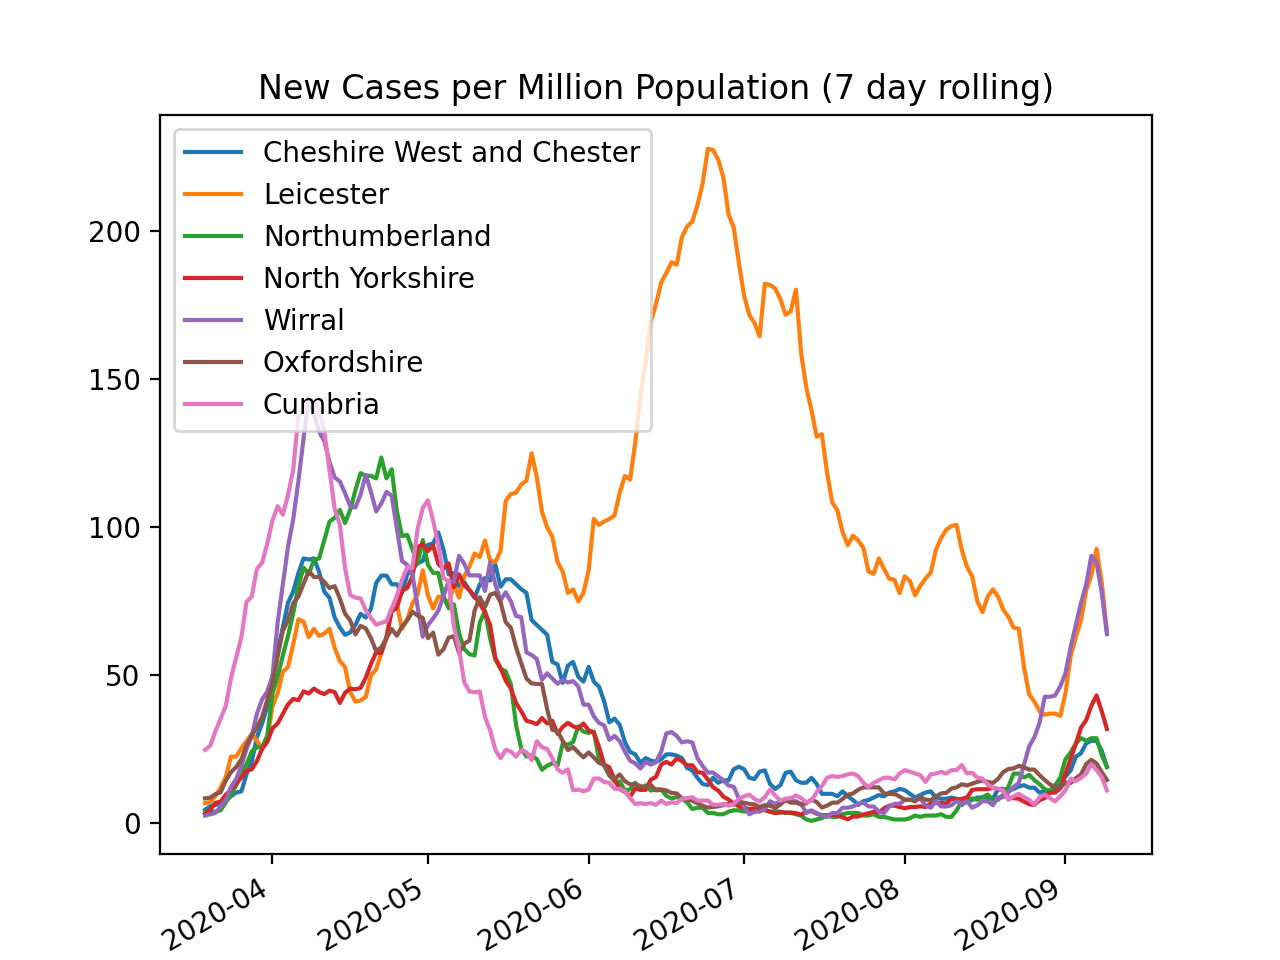

(array([737516., 737546., 737577., 737607., 737638., 737669.]),
 <a list of 6 Text major ticklabel objects>)

In [12]:
for utla in utlas:
    population_in_millions = int(df_utla_populations[df_utla_populations['Name']==utla]['Population']) / 10**6
    new_cases_per_million = joined_data_utlas[f"newCases{utla.replace(' ','')}"]/population_in_millions
    rolling_new_cases_per_million = rolling_average(new_cases_per_million,7)
    
    joined_data_utlas[f"newCasesPerMillion{utla.replace(' ','')}"] = new_cases_per_million
    joined_data_utlas[f"newCasesPerMillion7Day{utla.replace(' ','')}"] = rolling_new_cases_per_million

utlas_new_cases_columns = [f"newCasesPerMillion7Day{utla.replace(' ','')}" for utla in utlas]

joined_data_utlas.plot('date', utlas_new_cases_columns)
plt.legend(labels=utlas)
plt.title('New Cases per Million Population (7 day rolling)')
plt.xticks(rotation=30, ha='right')